In [1]:
import math, os

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [3]:
current_dir = os.getcwd()
lesson_dir = current_dir
data_dir = current_dir + '/data/catsdogs'
print(data_dir)
print(current_dir)

/home/ubuntu/nbs/courses/deeplearning2/data/catsdogs
/home/ubuntu/nbs/courses/deeplearning2


In [5]:
%matplotlib inline

In [6]:
%cd $data_dir

#Set path to sample/ path to run on sample data
path = data_dir
#path = data_dir + '/sample/'

test_path = data_dir + '/test/' 
results_path= data_dir + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

print (train_path)

/home/ubuntu/nbs/courses/deeplearning2/data/catsdogs
/home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/train/


In [7]:
import tensorflow
import keras
from keras import backend as K

Using TensorFlow backend.


In [8]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras import optimizers

from keras.models import *
from keras.layers import Dense
from keras.layers import *
from keras.callbacks import *

In [9]:
batch_size = 64

In [10]:
#Setting the number of epochs and steps for all models. When using sample directory, 
#number of datapoints is set to 600 and number of validation data points is set to 200

num_epochs = 30
num_data = 23000
num_valdata = 2000
#num_data = 600 # for samples
#num_valdata = 200 # for samples

In [11]:
steps = int(np.ceil(num_data/batch_size))
valid_steps = int(np.ceil(num_valdata/batch_size)) 

print(steps)
print(valid_steps)

360
32


In [12]:
#These data generators will be used by all the different models.

datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen = datagen.flow_from_directory(valid_path, target_size = (224, 224), 
                                            class_mode = 'categorical', batch_size = batch_size)

Found 2000 images belonging to 2 classes.



### Fine-tuning the last layer of a VGG model


In [13]:
base_model = VGG16(weights = 'imagenet')

In [15]:
#base_model.summary() 
#run this as needed to make sure your model is behaving as expected - model structure, number of trainable 
#parameters etc

In [14]:
# New model built with Keras functional API

last = base_model.layers[-2].output
preds = Dense(2, activation='softmax')(last)

new_model = Model(inputs=base_model.input, outputs = preds)

In [18]:
layers = new_model.layers

last_dense_index = [index for index,layer in enumerate(layers) if type(layer) is Dense][-1]

last_dense_index

22

In [16]:
for layer in new_model.layers[:22]: 
    layer.trainable = False
for layer in new_model.layers[22:]:
    layer.trainable = True

In [17]:
# Defining a function for compiling models

def m_compile (model, lrn):
    adam = optimizers.Adam(lr = lrn)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print ("compiled with lr ", lrn)

lr = 0.001
m_compile(new_model, lr)

compiled with lr  0.001


In [21]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
# Defining a function to fit/train the model. The same function can be used to train a model with augmented data.
# ModelCheckPoint saves the weights of the models when validation loss is lower
# Early stopping stops the models when no val_loss improvement in seen for a specific number of epochs

def m_fit(model, gen, filepath):
    print("Fitting {} with generator {}".format(model, gen))
    train_datagen = gen.flow_from_directory(train_path, target_size = (224, 224), 
                                            class_mode = 'categorical', batch_size = batch_size)
    callback_list = [  
    EarlyStopping(monitor='val_loss', patience=7, verbose=2),
    ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=2)]
    
    model.fit_generator(train_datagen, steps_per_epoch = steps, epochs = num_epochs, verbose = 2, 
                    validation_data = valid_datagen, validation_steps = valid_steps, callbacks = callback_list)


In [23]:
#Fit the model

filepath = results_path + "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
m_fit(new_model, datagen, filepath)

# Please note that I used keyboard interrupt on this model since it was clearly overfitting 
# and the epochs were taking a long time to train

Fitting <keras.engine.training.Model object at 0x7f5d6f1e75f8> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d6d6dd128>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.04741, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights.01-0.05.hdf5
 - 370s - loss: 0.0672 - acc: 0.9777 - val_loss: 0.0474 - val_acc: 0.9840
Epoch 2/30
Epoch 00002: val_loss did not improve
 - 352s - loss: 0.0383 - acc: 0.9873 - val_loss: 0.0864 - val_acc: 0.9800
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 351s - loss: 0.0271 - acc: 0.9904 - val_loss: 0.0695 - val_acc: 0.9800
Epoch 4/30
Epoch 00004: val_loss did not improve
 - 351s - loss: 0.0245 - acc: 0.9912 - val_loss: 0.0686 - val_acc: 0.9815
Epoch 5/30


KeyboardInterrupt: 

### Re-training all the Dense layers in VGG16

In [24]:
#Finding First Dense Layer
layers = new_model.layers

first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
first_dense_idx

20

In [25]:
first_dense_idx

20

In [26]:
for layer in new_model.layers[20:]: 
    layer.trainable = True
for layer in new_model.layers[:20]: 
    layer.trainable = False

In [27]:
m_compile(new_model, 0.000001)

# compiling with this learning rate based on trial and error. Model did not train for a larger learning rate

compiled with lr  1e-06


In [29]:
#Before training the last 3 layers, load the weights from finetuning the final layer. This will help 
#ensure that the weights do not move too far from the Imagenet weights

from keras.models import load_model

new_model.load_weights(results_path + "weights.01-0.05.hdf5")

In [31]:
#new_model.summary()

In [32]:
filepath = results_path + "weights_mul.{epoch:02d}-{val_loss:.2f}.hdf5"

m_fit(new_model, datagen, filepath)

# Used keyboard interrupt as the model was overfitting. 
# In hindsight, a lower number for Early Stopping would have been appropriate

Fitting <keras.engine.training.Model object at 0x7f5d6f1e75f8> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d6d6dd128>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.05023, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights_mul.01-0.05.hdf5
 - 393s - loss: 0.0294 - acc: 0.9906 - val_loss: 0.0502 - val_acc: 0.9830
Epoch 2/30
Epoch 00002: val_loss did not improve
 - 391s - loss: 0.0084 - acc: 0.9981 - val_loss: 0.0507 - val_acc: 0.9840
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 391s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0523 - val_acc: 0.9835
Epoch 4/30
Epoch 00004: val_loss did not improve
 - 390s - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0523 - val_acc: 0.9840
Epoch 5/30


KeyboardInterrupt: 

### Data Augmentation -Visualize Augmented Images

In [68]:
#Define generator with data augmentation criteria
datagen_aug_test = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, 
                                            height_shift_range=0.1, zoom_range=0.1, 
                                            shear_range=0.1, horizontal_flip=True)

In [69]:
from scipy import ndimage
from PIL import Image

# Create augmented batches from a single image
img = np.expand_dims(ndimage.imread('data/catsdogs/test/unknown/1.jpg'),0)
aug_iter = datagen_aug_test.flow(img)

In [70]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

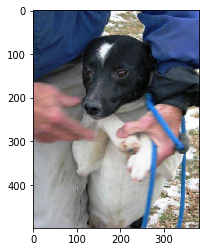

In [71]:
# Original image
plt.imshow(img[0])

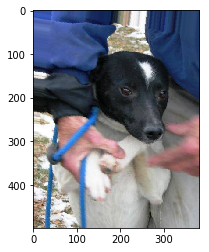

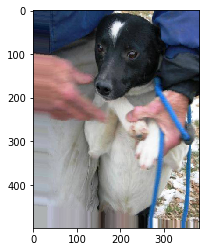

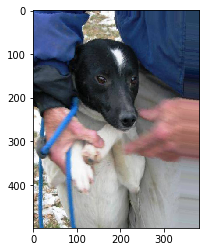

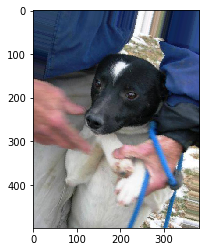

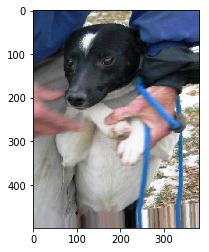

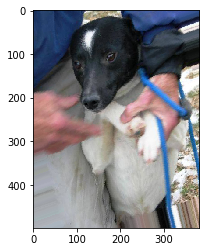

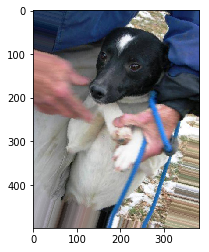

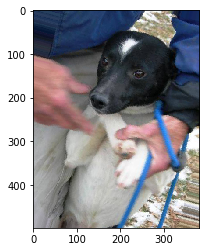

In [74]:
# Show all Augmented images

for image in aug_imgs:
    plt.imshow(image)
    plt.show()

### Training with Augmented Images

In [36]:
# Training with Augmented Images - here we are training with lower augmentation

new_model.load_weights(results_path + "weights.01-0.05.hdf5")

filepath = results_path + "weights_aug.{epoch:02d}-{val_loss:.2f}.hdf5"

datagen_aug = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20, 
                                      width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, 
                                      shear_range=0.1, horizontal_flip=True)

m_fit(new_model, datagen_aug, filepath)

Fitting <keras.engine.training.Model object at 0x7f5d6f1e75f8> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d4065bb38>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.04670, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights_aug.01-0.05.hdf5
 - 386s - loss: 0.0542 - acc: 0.9812 - val_loss: 0.0467 - val_acc: 0.9855
Epoch 2/30
Epoch 00002: val_loss improved from 0.04670 to 0.04410, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights_aug.02-0.04.hdf5
 - 383s - loss: 0.0402 - acc: 0.9857 - val_loss: 0.0441 - val_acc: 0.9860
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 383s - loss: 0.0326 - acc: 0.9877 - val_loss: 0.0444 - val_acc: 0.9850
Epoch 4/30
Epoch 00004: val_loss improved from 0.04410 to 0.04394, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights_aug.04-0.04.hdf5
 - 383s - loss: 0.0264 - acc: 0.9

In [ ]:
# Training with Augmented Images - here we are training with more augmentation

new_model.load_weights(results_path + "weights.01-0.05.hdf5")

filepath = results_path + "sweights_aug2.{epoch:02d}-{val_loss:.2f}.hdf5"

datagen_aug2 = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, 
                                       width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                       zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

m_fit(new_model, datagen_aug2, filepath)

Fitting <keras.engine.training.Model object at 0x7f5d6f1e75f8> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d42fa96a0>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.04245, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/sweights_aug2.01-0.04.hdf5
 - 391s - loss: 0.0786 - acc: 0.9720 - val_loss: 0.0424 - val_acc: 0.9850
Epoch 2/30
Epoch 00002: val_loss did not improve
 - 402s - loss: 0.0604 - acc: 0.9770 - val_loss: 0.0432 - val_acc: 0.9850
Epoch 3/30
Epoch 00003: val_loss improved from 0.04245 to 0.04174, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/sweights_aug2.03-0.04.hdf5
 - 403s - loss: 0.0586 - acc: 0.9776 - val_loss: 0.0417 - val_acc: 0.9865
Epoch 4/30
Epoch 00004: val_loss improved from 0.04174 to 0.04099, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/sweights_aug2.04-0.04.hdf5
 - 403s - loss: 0.0516 - ac

### Training Models with Dropout

The VGG model in Keras does not include dropout in the Dense layers, while the orginal VGG model did. Here, we add dropout to the model to see if it can reduce overfitting.

In [34]:
#This builds a model with a specified dropout, compiles the model and fits the model

def m_build (d, gen, filepath):
    last2 = base_model.layers[-3].output
    x = Dropout(d)(last2)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(d)(x)
    predictions = Dense(2, activation='softmax')(x)
    drop_model = Model(inputs=base_model.input, outputs = predictions)
      
    for layer in drop_model.layers[20:]: 
        layer.trainable = True
    for layer in drop_model.layers[:20]:
        layer.trainable = False
    
    m_compile(drop_model, 0.00001)
    
    m_fit(drop_model, gen, filepath)
    
    return drop_model

In [37]:
# First model with 0.7 dropout

filepath = results_path + "weights_drop1.{epoch:02d}-{val_loss:.2f}.hdf5"
drop_model1 = m_build(0.7, datagen, filepath)

# The model was interrupted while training, but I did not re-train since the val_loss was staying high 
# Also, based on running the same model on a sample and by looking at the model with dropout of 0.5, 
# it seemed very unlikely that this model would outperform the benchmark


compiled with lr  1e-05
Fitting <keras.engine.training.Model object at 0x7f5d4063ff60> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d6d6dd128>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.15945, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/weights_drop1.01-0.16.hdf5
 - 398s - loss: 0.7308 - acc: 0.9210 - val_loss: 0.1594 - val_acc: 0.9820
Epoch 2/30
Epoch 00002: val_loss did not improve
 - 396s - loss: 0.2702 - acc: 0.9717 - val_loss: 0.1627 - val_acc: 0.9825
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 396s - loss: 0.1826 - acc: 0.9816 - val_loss: 0.1810 - val_acc: 0.9825
Epoch 4/30
Epoch 00004: val_loss did not improve
 - 399s - loss: 0.1703 - acc: 0.9822 - val_loss: 0.1803 - val_acc: 0.9845
Epoch 5/30
Epoch 00005: val_loss did not improve
 - 400s - loss: 0.1502 - acc: 0.9851 - val_loss: 0.1918 - val_acc: 0.9845
Epoch 6/30


KeyboardInterrupt: 

In [6]:
#drop_model1.summary()

In [35]:
# 0.5 dropout
filepath = results_path + "sweights_drop2.{epoch:02d}-{val_loss:.2f}.hdf5"
drop_model2 = m_build(0.5, datagen, filepath)

compiled with lr  1e-05
Fitting <keras.engine.training.Model object at 0x7f5d42e75c88> with generator <keras.preprocessing.image.ImageDataGenerator object at 0x7f5d6d6dd128>
Found 23000 images belonging to 2 classes.
Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.11405, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/sweights_drop2.01-0.11.hdf5
 - 389s - loss: 0.2735 - acc: 0.9601 - val_loss: 0.1140 - val_acc: 0.9830
Epoch 2/30
Epoch 00002: val_loss did not improve
 - 387s - loss: 0.0961 - acc: 0.9862 - val_loss: 0.1338 - val_acc: 0.9830
Epoch 3/30
Epoch 00003: val_loss improved from 0.11405 to 0.10930, saving model to /home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/results/sweights_drop2.03-0.11.hdf5
 - 384s - loss: 0.0754 - acc: 0.9890 - val_loss: 0.1093 - val_acc: 0.9865
Epoch 4/30
Epoch 00004: val_loss did not improve
 - 383s - loss: 0.0394 - acc: 0.9937 - val_loss: 0.1215 - val_acc: 0.9865
Epoch 5/30
Epoch 00005: val_loss did not improve


### Generate Test File Predictions, Clip and Submit predictions

In [18]:
new_model.load_weights(results_path + "sweights_aug2.12-0.04.hdf5") # Loading the model with the best result

test_batch = 64
test_steps = int(np.ceil(12500/test_batch))

def test_predict(model, path):
    test_datagen = datagen.flow_from_directory(test_path, target_size = (224, 224), 
                                            class_mode = 'categorical', batch_size = test_batch, shuffle = False)
    test_preds = model.predict_generator(test_datagen, steps = test_steps, max_queue_size=10, workers=1, 
                               use_multiprocessing=False, verbose=0)  
    return test_datagen, test_preds

batches, preds = test_predict(new_model, test_path)

Found 12500 images belonging to 1 classes.


In [19]:
#Preds contains two probabilities for each image - probablity it is a dog and probability it is a cat
#It looks like column one is cats and column two is dogs
print (preds[:5])

filenames = batches.filenames
print (filenames[:5])

# this prints out the first 5 rows of predictions. 

[[  1.15644823e-07   9.99999881e-01]
 [  9.99999881e-01   6.55484698e-08]
 [  9.99994874e-01   5.18553225e-06]
 [  7.21389455e-08   9.99999881e-01]
 [  2.86386162e-03   9.97136116e-01]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg', 'unknown/10000.jpg']


In [21]:
#The values are clipped since logloss penalizes predictions that are very confident and wrong
#Clipping and test file generation code uses snippets from www.fast.ai
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)

In [22]:
#Extract imageIds from the filenames 
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [23]:
ids[:5]

array([    1,    10,   100,  1000, 10000])

In [24]:
submiss = np.stack([ids,isdog], axis=1)
submiss[:5]

array([[  1.00000000e+00,   9.49999988e-01],
       [  1.00000000e+01,   5.00000007e-02],
       [  1.00000000e+02,   5.00000007e-02],
       [  1.00000000e+03,   9.49999988e-01],
       [  1.00000000e+04,   9.49999988e-01]])

In [25]:
%cd $data_dir
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, submiss, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/nbs/courses/deeplearning2/data/catsdogs


In [26]:
from IPython.display import FileLink
%cd $lesson_dir
FileLink('data/catsdogs/'+submission_file_name)

/home/ubuntu/nbs/courses/deeplearning2


/home/ubuntu/nbs/courses/deeplearning2/data/catsdogs/submission1.csv